# Import

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from itertools import combinations
from frechetdist import frdist
from sklearn.metrics.pairwise import cosine_similarity
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cosine
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Heatmap

Visualize the results using a Seaborn heatmap. The file path can be adjusted to specify the dataset or model score to be plotted. In the example provided, the heatmap illustrates the accuracy scores across different configurations or feature sets. This visualization highlights patterns and variations in performance, making it easier to identify the best feature set.

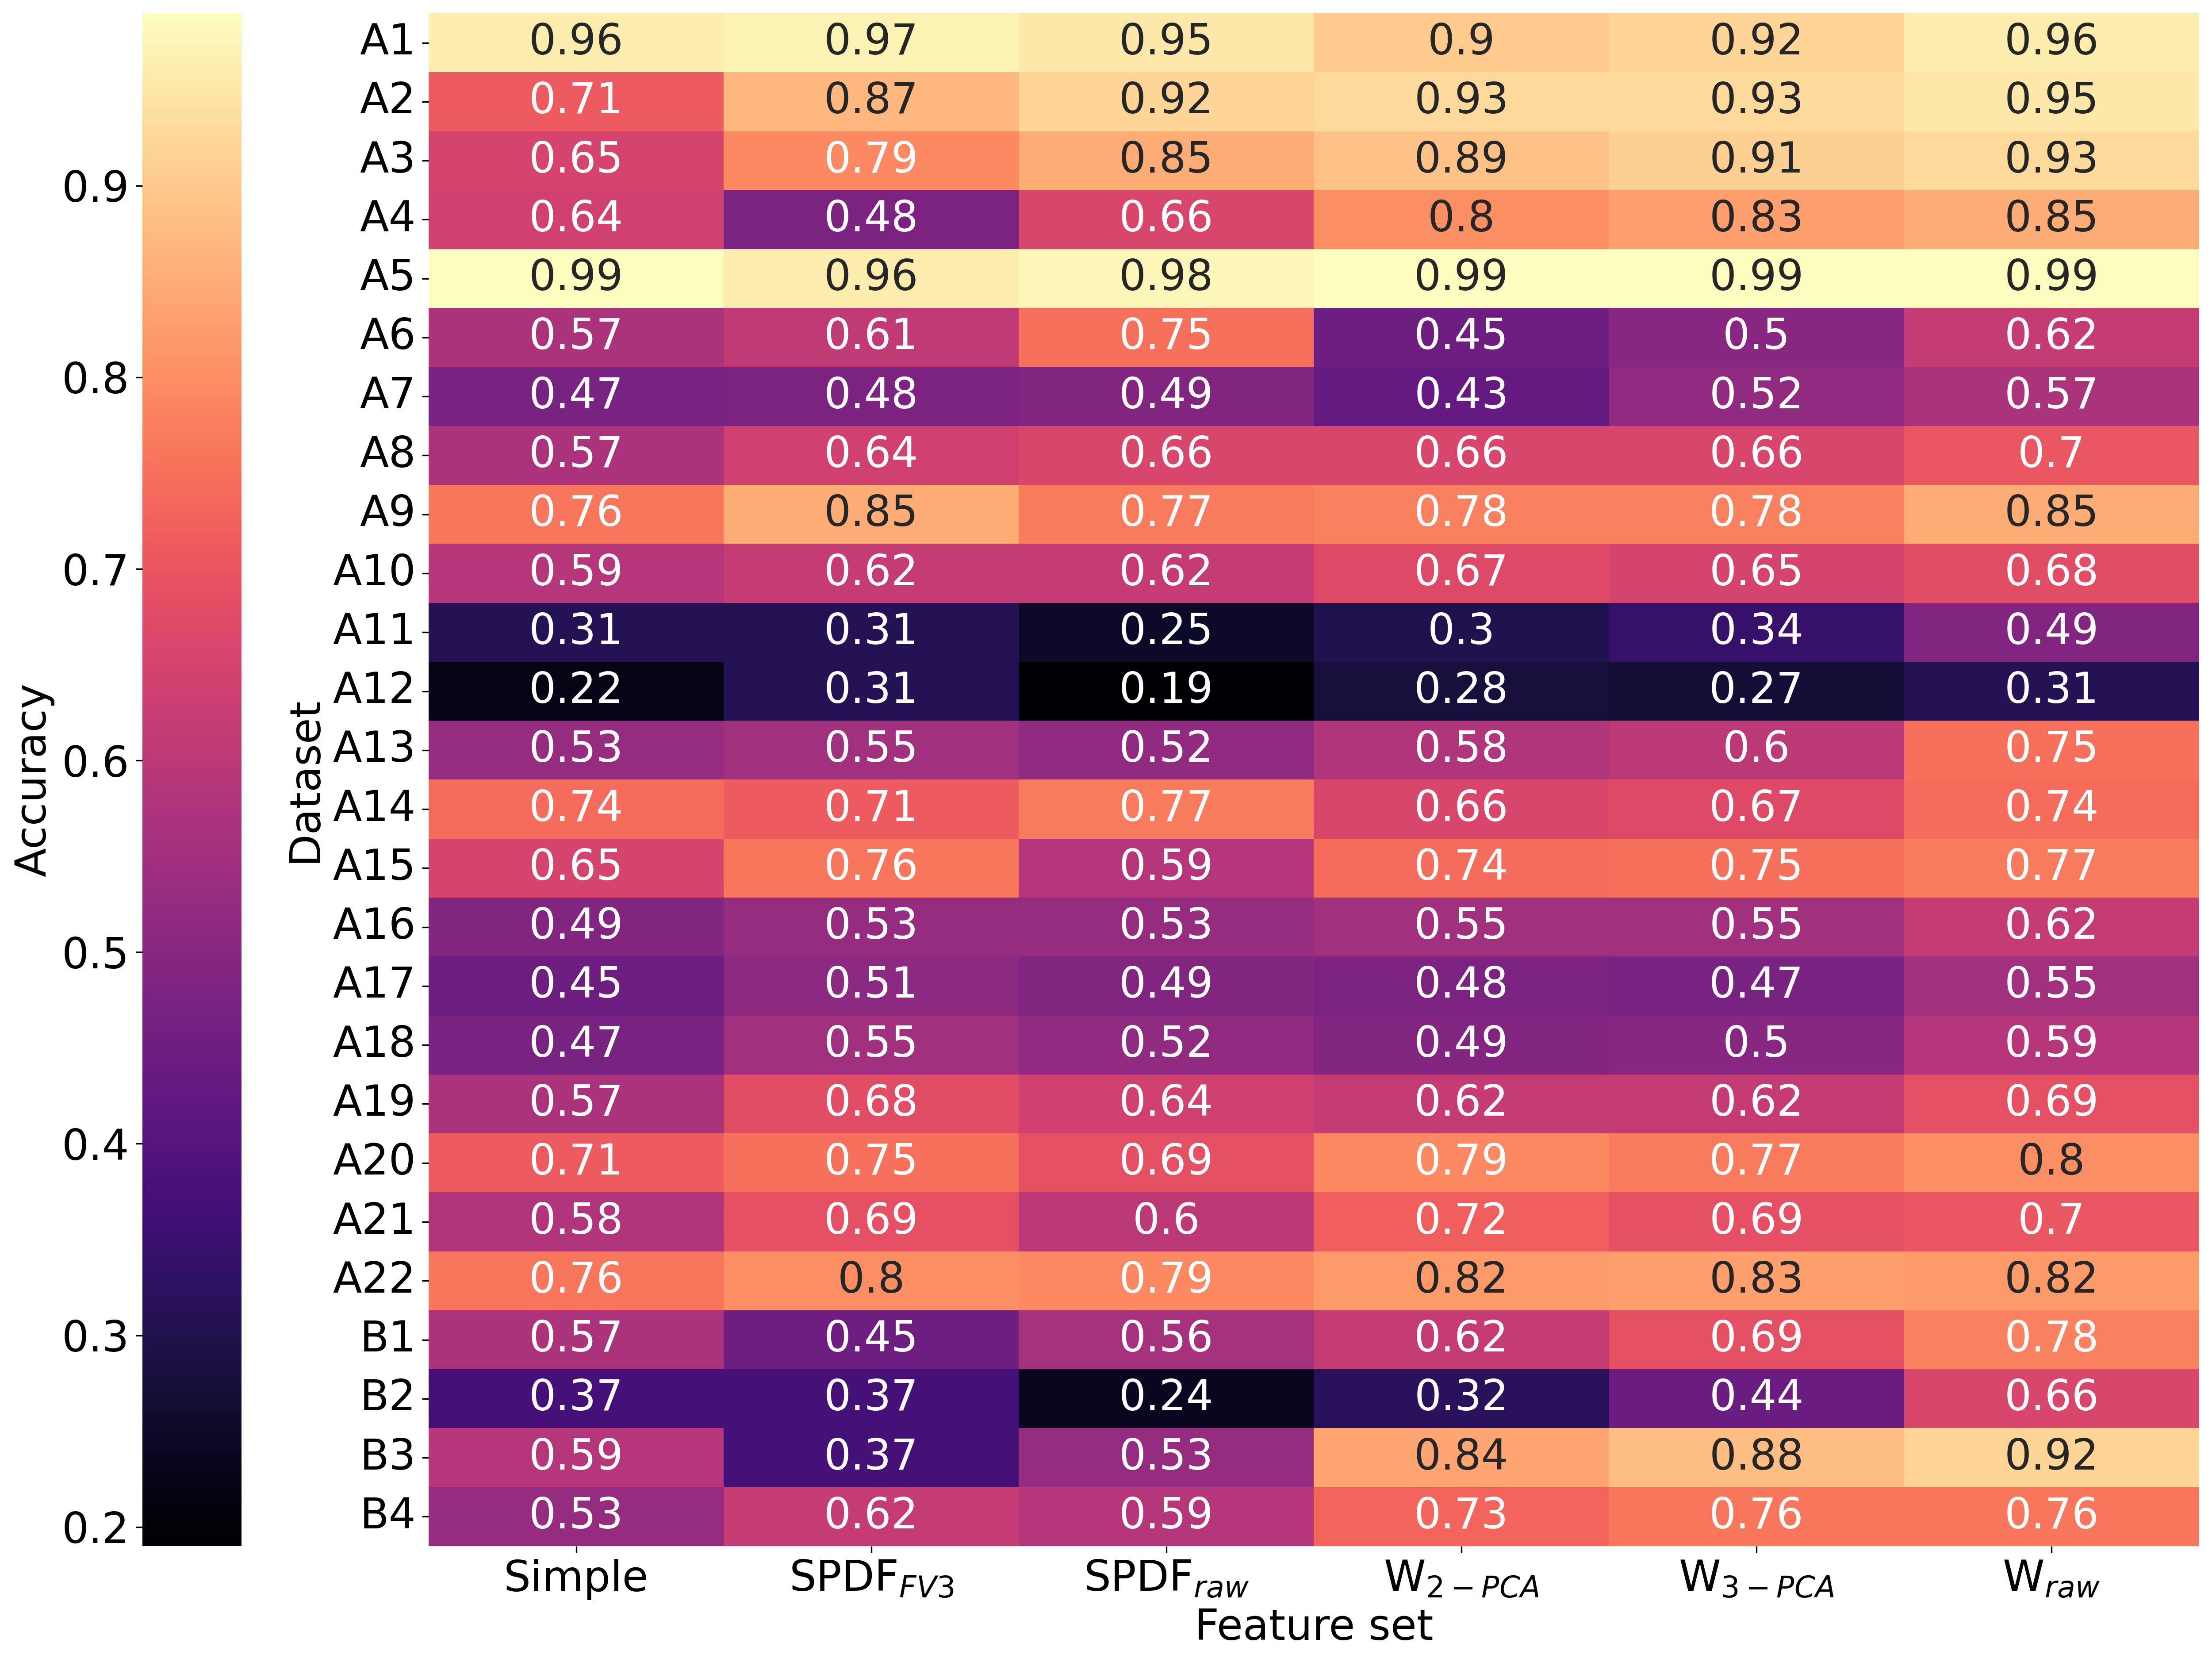

In [5]:
df_result = pd.read_csv(r"accuracy.csv")
#df_result = pd.read_csv(r"C:\Users\alina\Documents\UKA\Paper\Spike shape paper\PLOS submission\PLOS one\Revision\code\SpikeSortingPipeline-snakemake\results_new_al_no_filter\classification_split\accuracy.csv")
df_result_index = df_result.set_index('Dataset')[["FS1", "FS2","FS3", "FS4","FS5", "FS6"]]   
df_result_index.rename(columns={'FS1': 'Simple', 'FS2': "SPDF$_{FV3}$", 'FS3': "SPDF$_{raw}$"
                        , 'FS4': "W$_{2-PCA}$", 'FS5': "W$_{3-PCA}$",
                        'FS6': "W$_{raw}$"}, inplace=True)
# Option to inclde mean 
#df_result_index['Mean Col'] = df_result_index.mean(axis = 1)  #### mean column
#df_result_index.loc["Mean Row"] = df_result_index.mean()  #### mean row
df_result_index = df_result_index.round(2)
grid_spec = {"width_ratios": (.05, .89)}
fig, (cbar_ax,ax ) = plt.subplots(1,2, gridspec_kw=grid_spec, figsize=(20,15),dpi = 300) 
sns.heatmap(df_result_index, annot=True, fmt="g", cmap='magma', ax = ax,  
        annot_kws={"fontsize":23},  cbar_ax=cbar_ax, cbar_kws={ 'location':"left",'orientation':"vertical", 'label':"Accuracy"})
ax.xaxis.set_tick_params(labelsize=23)
ax.yaxis.set_tick_params(labelsize=23, rotation=0)
ax.set_xlabel("Feature set", fontsize=23)
ax.set_ylabel("Dataset", fontsize=23)
cbar_ax.yaxis.label.set_size(23)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=23)

# Statistical Analysis

For the statistical analysis, we employed the Wilcoxon signed-rank test to compare paired samples. The initial significance level (alpha) was set at 0.01 to control for Type I errors. To further adjust for multiple comparisons, we applied the Bonferroni correction, reducing the risk of false positives. This method ensures robust and reliable insights into the data's statistical significance.

In [6]:
# groups values for each feature from data frame 
group1 = df_result["FS1"].values
group2 = df_result["FS2"].values
group3 = df_result["FS3"].values
group4 = df_result["FS4"].values
group5 = df_result["FS5"].values
group6 = df_result["FS6"].values
groups = [group1, group2, group3, group4, group5, group6]
# create pairs for each combination (21)
group_pairs = list(combinations(range(len(groups)), 2))
p_values = []

for i, j in group_pairs:
    # two related samples, always the same recordings 
    t_stat, p_value = stats.wilcoxon(groups[i], groups[j])
    p_values.append(p_value)
    
n_tests = len(p_values)
alpha = 0.01
bonferroni_alpha = alpha / n_tests  
count_sig = 0
count_n = 0
for idx, (i, j) in enumerate(group_pairs):
    if p_values[idx] < bonferroni_alpha:
        print(f"FS {i+1} vs FS {j+1}: *, p-value {round(p_values[idx],8)}")
    else:
        print(f"FS {i+1} vs FS {j+1}: NS, p-value {round(p_values[idx],8)}")


FS 1 vs FS 2: NS, p-value 0.0355593
FS 1 vs FS 3: NS, p-value 0.08902901
FS 1 vs FS 4: NS, p-value 0.00433565
FS 1 vs FS 5: *, p-value 0.00044158
FS 1 vs FS 6: *, p-value 2.667e-05
FS 2 vs FS 3: NS, p-value 0.62688827
FS 2 vs FS 4: NS, p-value 0.63484961
FS 2 vs FS 5: NS, p-value 0.19629652
FS 2 vs FS 6: *, p-value 2.808e-05
FS 3 vs FS 4: NS, p-value 0.03456346
FS 3 vs FS 5: NS, p-value 0.00974303
FS 3 vs FS 6: *, p-value 1.907e-05
FS 4 vs FS 5: NS, p-value 0.01259423
FS 4 vs FS 6: *, p-value 3.01e-05
FS 5 vs FS 6: *, p-value 2.171e-05


C:\Users\alina\Documents\UKA\venvs\openmnglab_dev-venv\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


# Mean Score Value for Each Feature Colored by Fiber Number

This plot depicts the mean accuracy score for each individual feature set, with color coding to represent the number of fibers or tracks per recording. The visualization provides an intuitive understanding of how feature performance correlates with the number of fibers. A dashed line is included to indicate the baseline accuracy expected from a random classifier, serving as a reference for performance evaluation.

(0.0, 1.1)

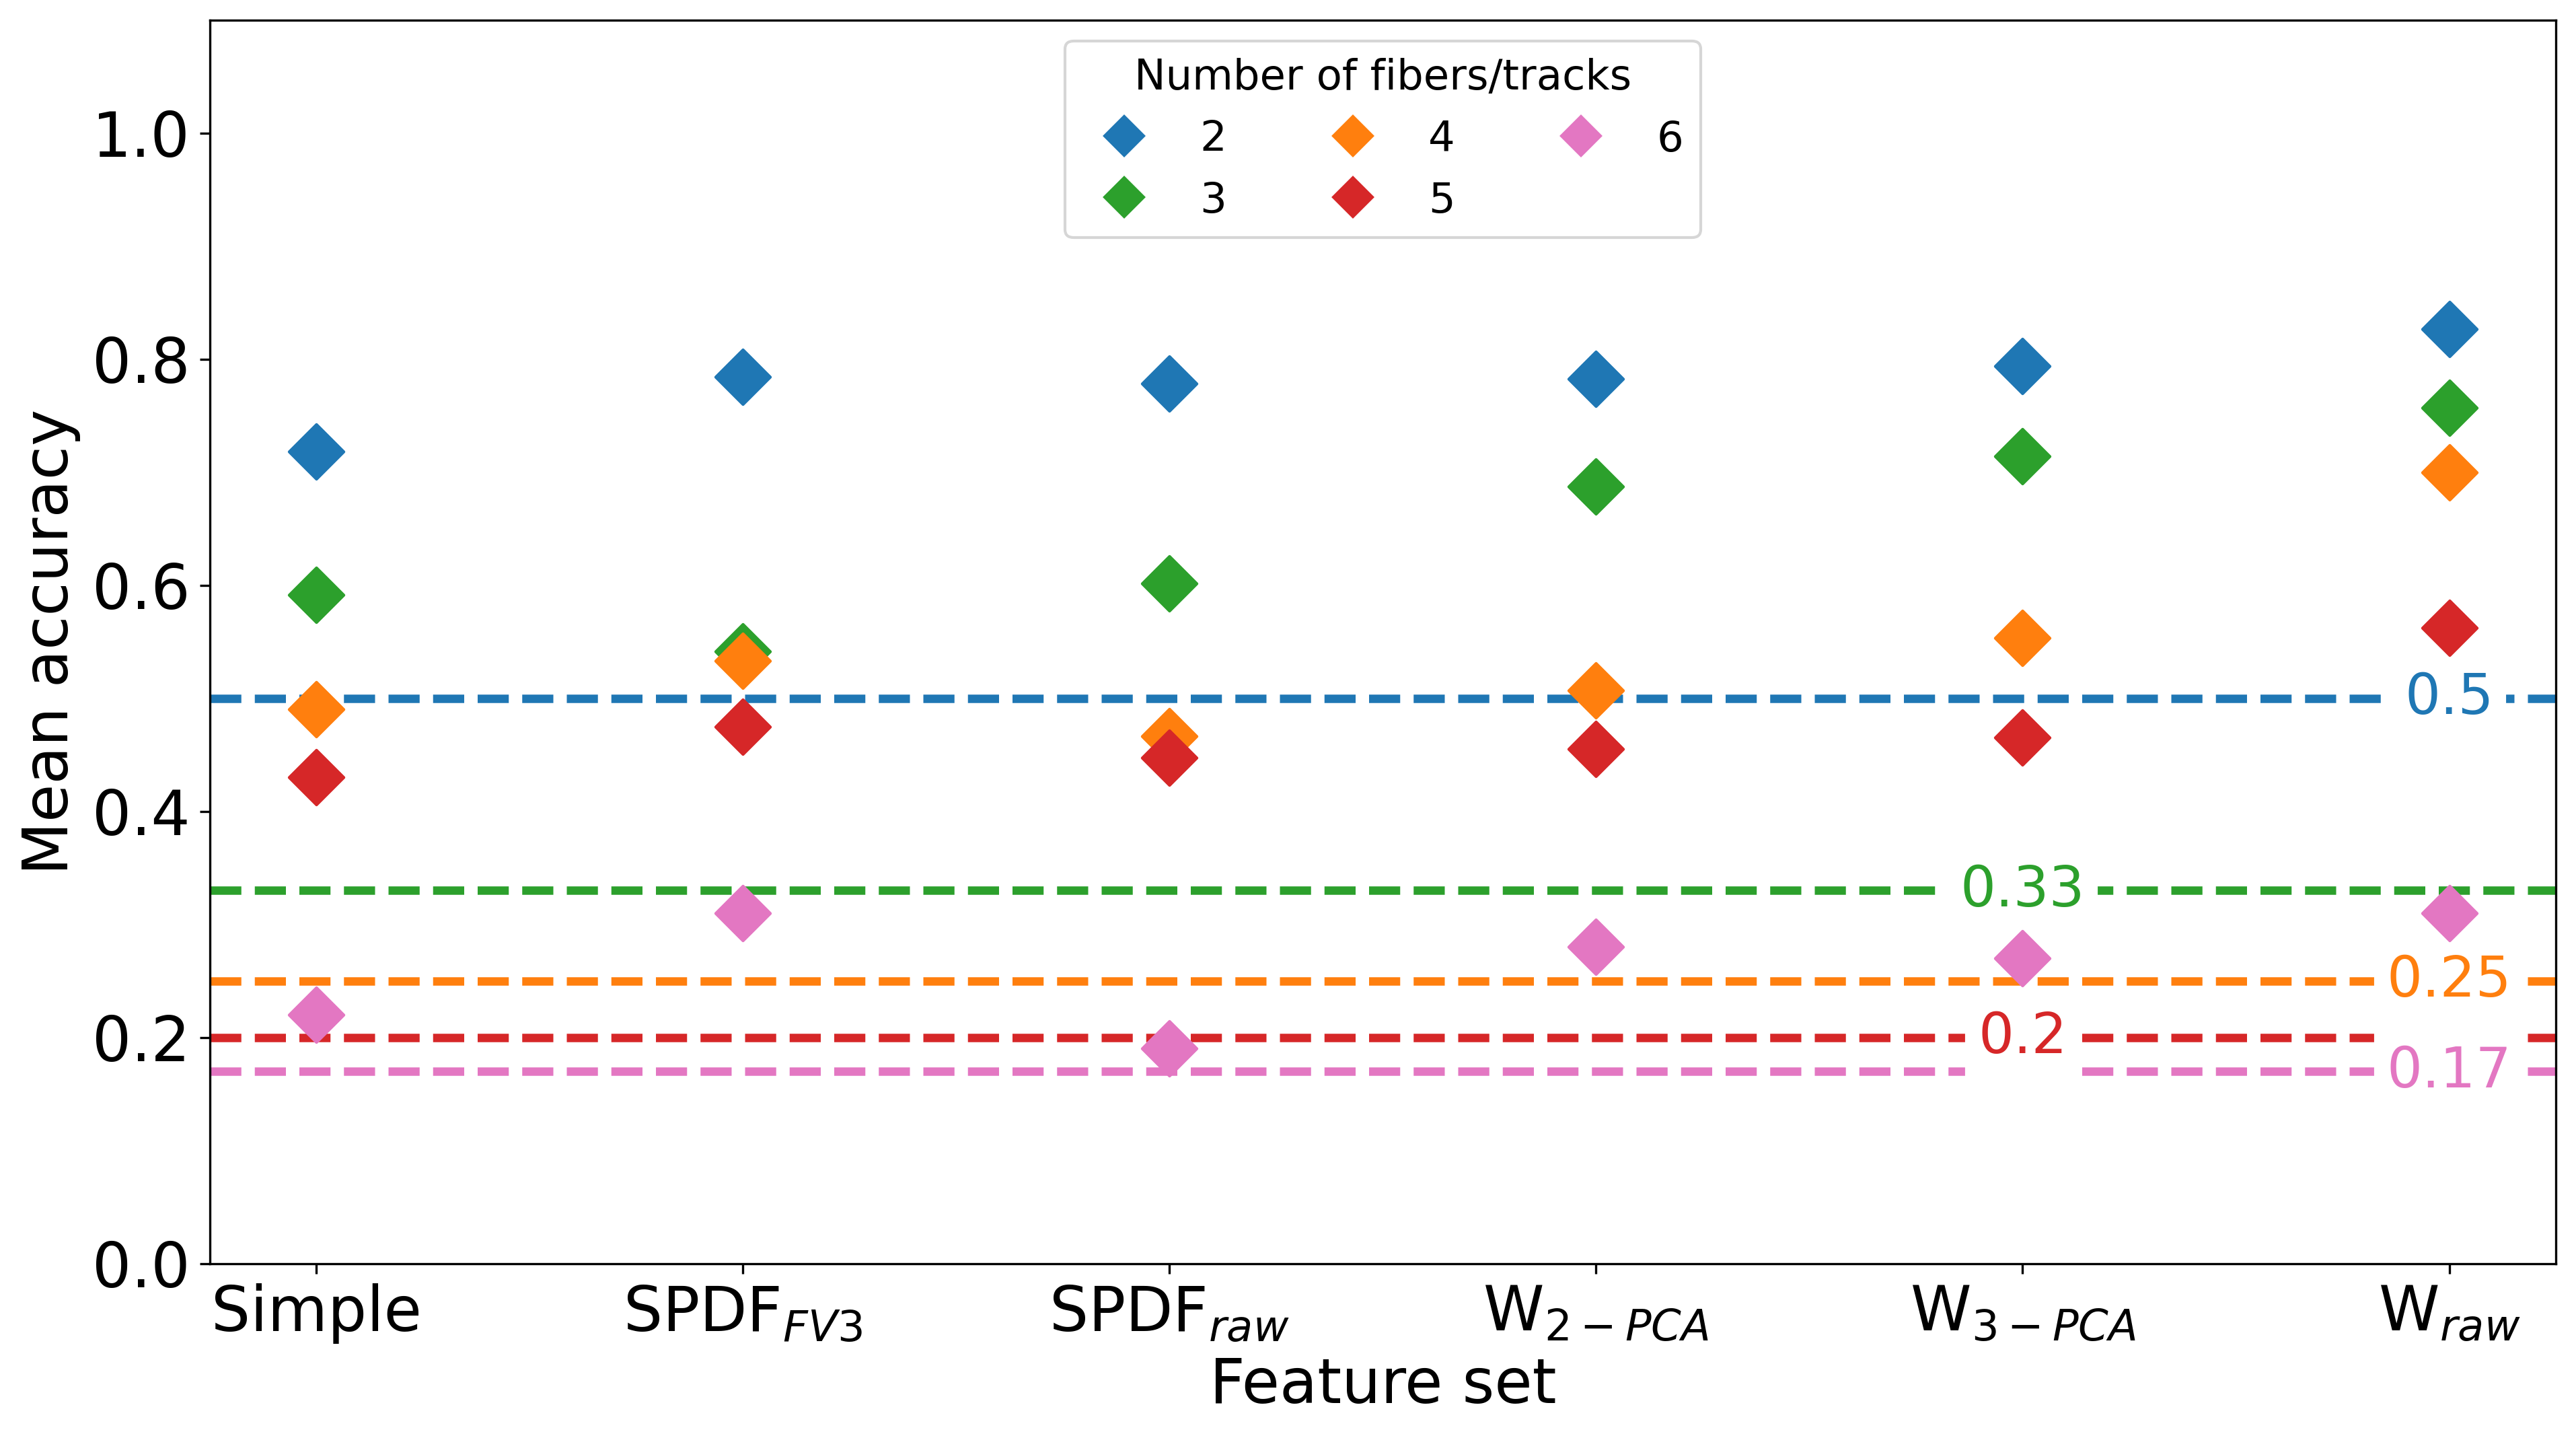

In [9]:
df = pd.read_csv(r"accuracy.csv")
#df = pd.read_csv(r"C:\Users\alina\Documents\UKA\Paper\Spike shape paper\PLOS submission\PLOS one\Revision\code\SpikeSortingPipeline-snakemake\results_new_al_no_filter\classification_split\accuracy.csv")

fig, ax = plt.subplots(figsize=(15,8), dpi=300)
# encode fiber count in a recording by color
fiber_number_c = {2:"tab:blue", 3:"tab:green", 4:"tab:orange", 5:"tab:red", 6:"tab:pink"}
# add baseline for random classifier
for n_f in fiber_number_c.keys():
    ax.axhline(y=round(1/n_f,2), color=fiber_number_c[n_f], linestyle='--', linewidth=3, label="Random chance accuracy")
    if (round(1/n_f,2) == 0.2) or (round(1/n_f,2) == 0.33):
        plt.text("W$_{3-PCA}$",round(1/n_f,2), str(round(1/n_f,2)), fontsize=20, va='center', ha='center', backgroundcolor='w',color=fiber_number_c[n_f])
    else:
        plt.text("W$_{raw}$",round(1/n_f,2), str(round(1/n_f,2)), fontsize=20, va='center', ha='center', backgroundcolor='w', color=fiber_number_c[n_f])
        
for i, df_track in df.groupby(["Number of tracks"]):
    df_index = df_track.set_index('Dataset')[["FS1", "FS2","FS3", "FS4","FS5", "FS6"]]      
    df_index.rename(columns={'FS1': 'Simple', 'FS2': "SPDF$_{FV3}$", 'FS3': "SPDF$_{raw}$"
                        , 'FS4': "W$_{2-PCA}$", 'FS5': "W$_{3-PCA}$",
                        'FS6': "W$_{raw}$"}, inplace=True)
    df_mean = df_index.mean(axis=0)
    ax.scatter(df_mean.index, df_mean.values,c= fiber_number_c[i[0]], s=190, marker="D", zorder=10)
markers = [plt.Line2D([0,0],[0,0],color=color, marker='D', linestyle='') for color in fiber_number_c.values()]
lgnd = ax.legend(markers, fiber_number_c.keys(), numpoints=1,fontsize=15, title="Number of fibers/tracks", title_fontsize=15, 
                ncol=3, loc=9)
for idx_lg in range(len(lgnd.legend_handles)):
    lgnd.legend_handles[idx_lg].set_markersize(10)
ax.set_xlabel("Feature set", fontsize=22)
ax.set_ylabel("Mean accuracy", fontsize=22)
ax.xaxis.set_tick_params(labelsize=22)
ax.yaxis.set_tick_params(labelsize=22, rotation=0)
ax.set_ylim((0,1.1))

# Boxplot

A boxplot is created for each feature set to display the distribution of accuracy scores. This visualization summarizes key statistical properties such as the median, interquartile range (IQR), and potential outliers. It allows for quick comparison of score variability across different feature sets, highlighting consistent performers or those with wide-ranging results.

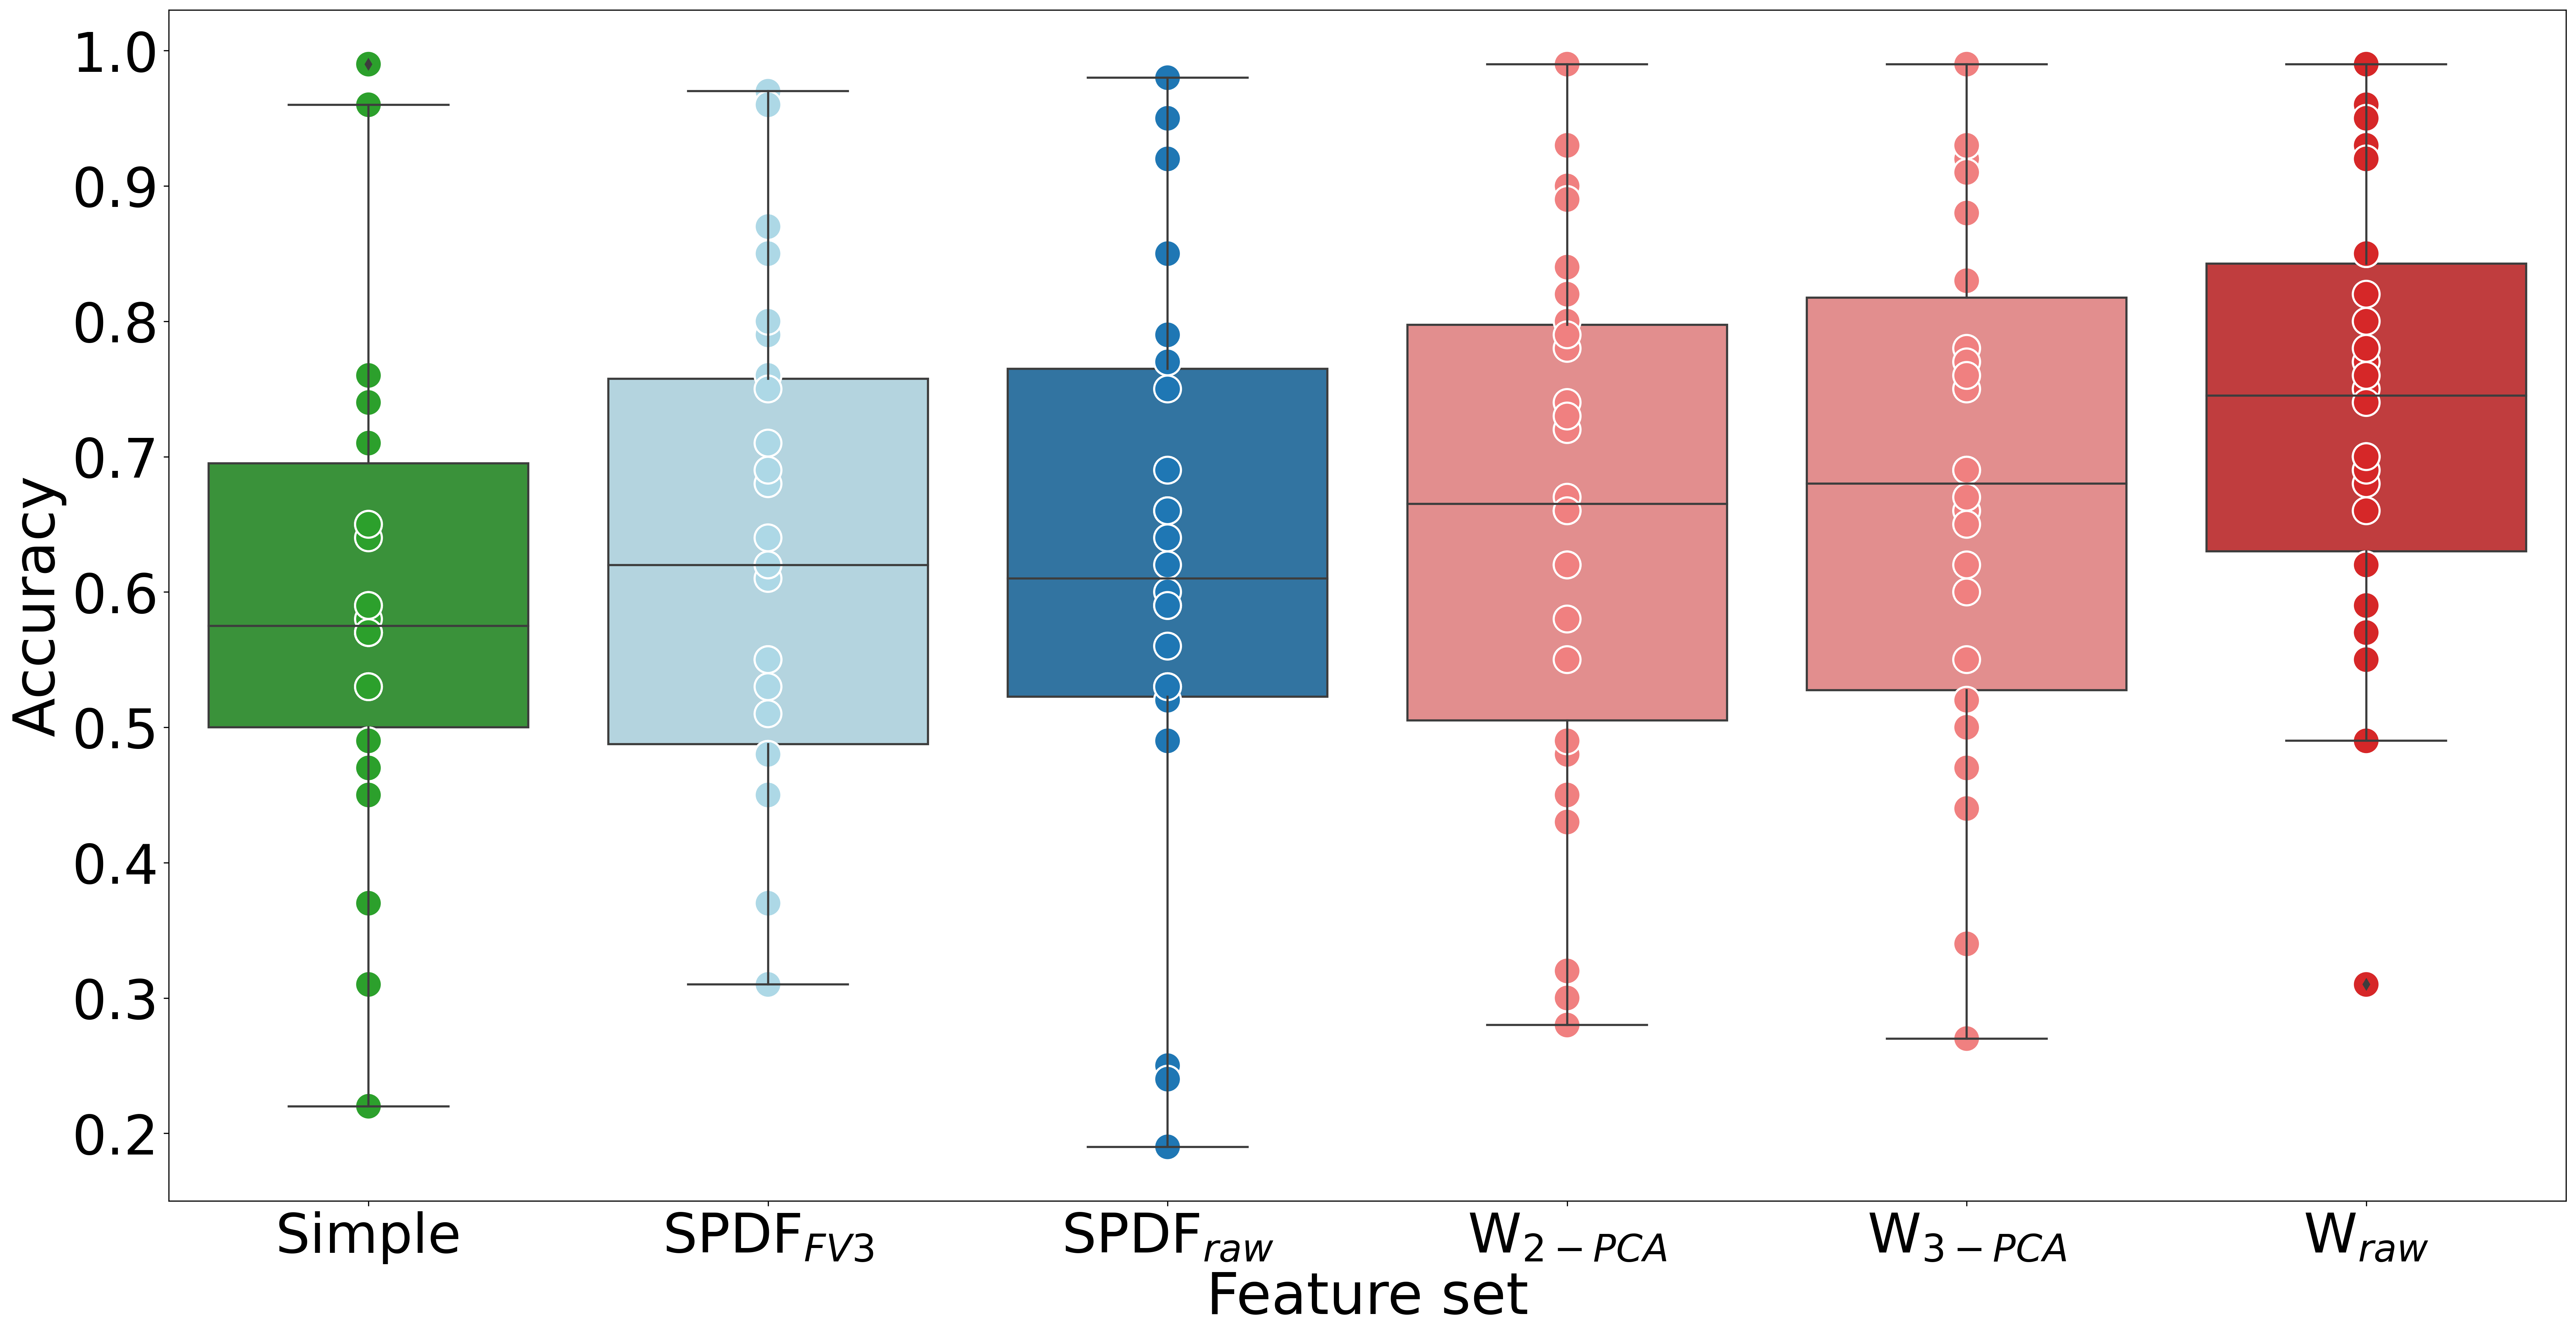

In [11]:
my_pal = {"versicolor": "g", "setosa": "b", "virginica":"m"}
df_result_index.rename(columns={'FS1': 'Simple', 'FS2': "SPDF$_2$", 'FS3': "SPDF$_3$"
                        , 'FS4': "SPDF$_{raw}$", 'FS5': "W$_2$",
                        'FS6': "W$_3$", 'FS7': "W$_{raw}$"}, inplace=True)
df_result_copy = df_result_index.copy()
df_index_melt = df_result_index.melt(var_name='Feature Set', value_name='Accuracy')

fig, ax = plt.subplots(figsize=(30,15), dpi=300)
my_pal = {"Simple": "tab:green", "SPDF$_{raw}$": "tab:blue", "SPDF$_{FV3}$": "lightblue",  "W$_{raw}$": "tab:red", "W$_{3-PCA}$": "lightcoral", "W$_{2-PCA}$":"lightcoral"}

#color_list = list(df_index_melt["variable"].map(my_pal))
sns.boxplot(x='Feature Set', y='Accuracy', data=df_index_melt, palette=my_pal)
sns.scatterplot(x='Feature Set', y='Accuracy', data=df_index_melt, s=350,hue='Feature Set',
              palette=my_pal, legend=False)
ax.set_xlabel("Feature set", fontsize=40)
ax.set_ylabel("Accuracy", fontsize=40)
ax.xaxis.set_tick_params(labelsize=38)
ax.yaxis.set_tick_params(labelsize=38, rotation=0)

# Template Similarity Distance

This analysis uses the templates and their associated accuracy scores to compute various distance error metrics. The computed metrics include:

   * Mean Absolute Error (MAE): Measures the average magnitude of errors without considering their direction.
   * Mean Squared Error (MSE): Provides a quadratic measure of errors, giving higher weight to larger discrepancies.
   * Root Mean Square Error (RMSE): Offers a standardized metric, as the square root of MSE, making it comparable to the original scale of the data.

These metrics provide a comprehensive assessment of the differences between template predictions and actual values, aiding in model evaluation and 'sortability' of a recording based on the template similarity. 

In [35]:
# path to template for recordings with two fibers
df_temp = pd.read_csv(r"templates and max SVM accuracy.txt", delimiter=";")

# method to compute RMSE for two templates
def compute_RMSE_templates(template1, template2):
    squared_differences = (template1 - template2) ** 2
    mse = np.mean(squared_differences)
    rmse = np.sqrt(mse)
    return(rmse)

# read in array from file
def read_str_template(template_str):
    template_str = template_str.replace("[", "")
    template_str = template_str.replace("]", "")
    return np.array([float(s) for s in template_str.split(",")])

# save all values in dicts for each dataset
max_accuracy = {}
rmse = {}
mae = {}
mse = {}
# iterate over all datasets/recordings
for i in range(len(df_temp)):
    dataset_name = df_temp["Dataset"][i]
    template1 = read_str_template(df_temp["template1"][i])
    template2 = read_str_template(df_temp["template2"][i])
    max_accuracy[dataset_name] = df_temp["max_acc"][i]
    RMSE[dataset_name] = compute_RMSE_templates(template1, template2)
    mae[dataset_name] = mean_absolute_error(template1, template2)
    mse[dataset_name] = mean_squared_error(template1, template2)
# sort score dicts    
mse_sorted =  dict(sorted(mse.items(), key=lambda item: item[1]))
mae_sorted =  dict(sorted(mae.items(), key=lambda item: item[1]))
RMSE_sorted =  dict(sorted(RMSE.items(), key=lambda item: item[1]))

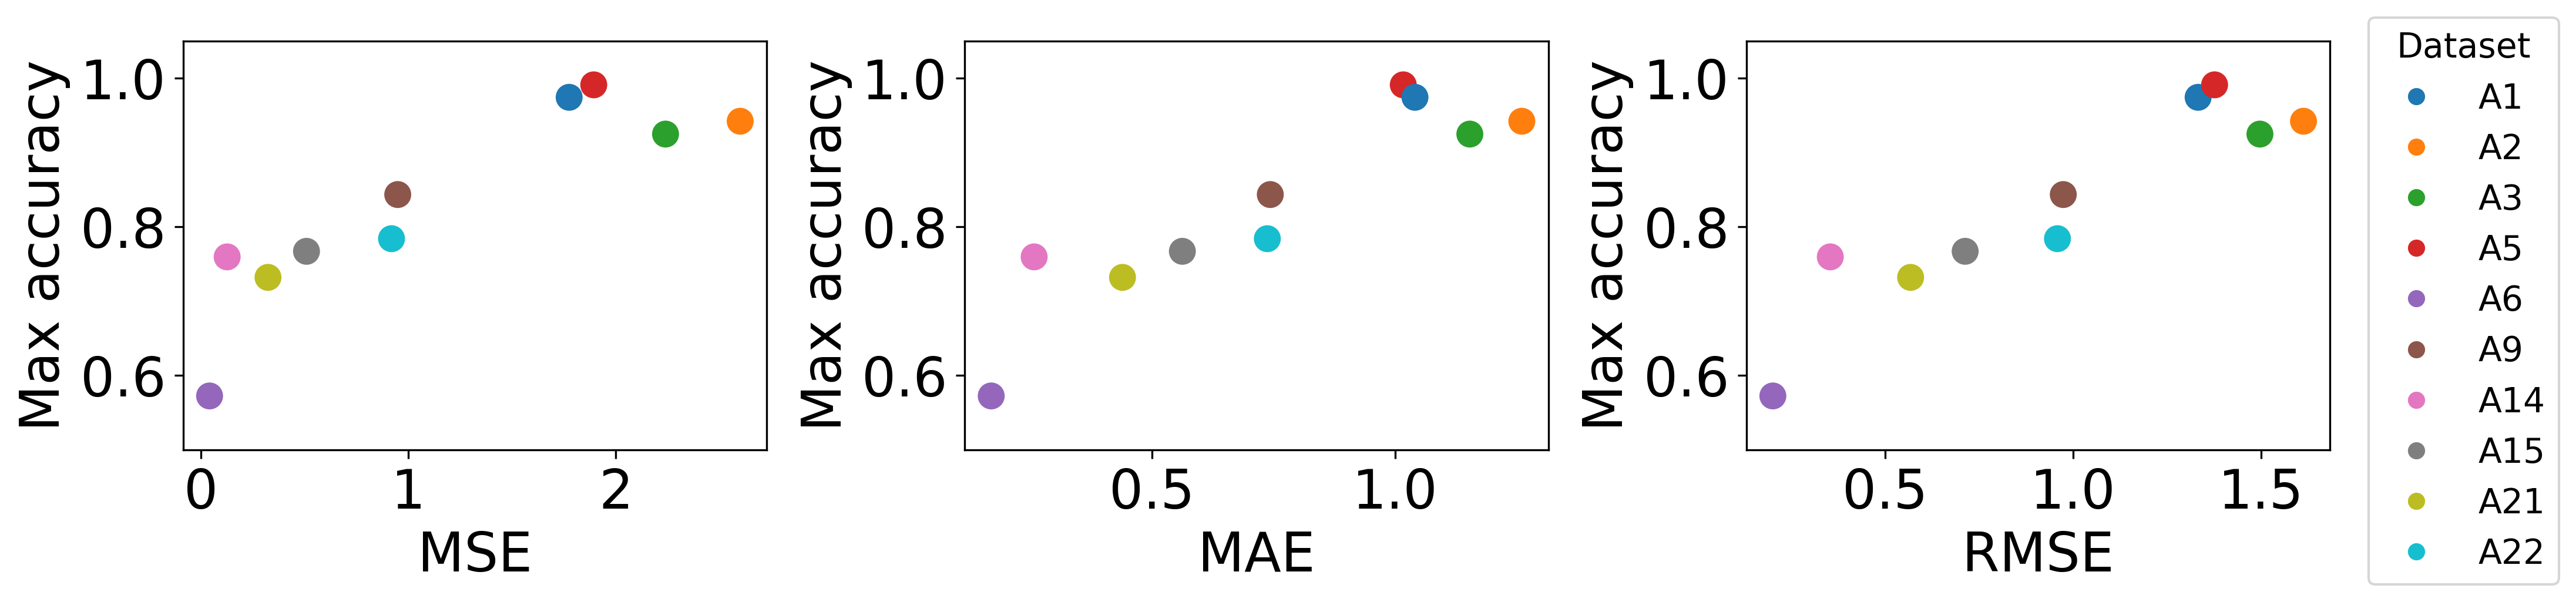

In [36]:
# plot distances and max accuracy
colors = {"A1":'tab:blue', "A2":'tab:orange', "A3":'tab:green', "A5":'tab:red', "A6":'tab:purple',
          "A9":'tab:brown',"A14":'tab:pink',"A15":'tab:gray', "A21":'tab:olive', "A22":'tab:cyan'}
fig, axs = plt.subplots(1, 3, figsize=(14, 4), dpi=300)
fig.tight_layout(pad=5.0)
axs[0].scatter(mse_sorted.values(),  [max_accuracy[k] for k in mse_sorted.keys()], s=100, c=[colors[k]for k in mse_sorted.keys()],marker="o", label="MSE")
axs[1].scatter(mae_sorted.values(), [max_accuracy[k] for k in mae_sorted.keys()], s=100, c=[colors[k]for k in mae_sorted.keys()], marker="o",label="MAE")
axs[2].scatter(RMSE_sorted.values(),  [max_accuracy[k] for k in RMSE_sorted.keys()], s=100, c=[colors[k]for k in RMSE_sorted.keys()], marker="o",label="RMSE")
markers = [plt.Line2D([0,0],[0,0],color=c, marker='o', linestyle='') for c in colors.values()]
lgnd =axs[0].legend(markers, colors.keys(), numpoints=1,fontsize=14, title="Dataset", title_fontsize=14, 
                ncol=1, bbox_to_anchor=(4.1, 1.1))
metric_list = ["MSE", "MAE", "RMSE"]
for idx, ax in enumerate(axs):
    ax.set_xlabel(metric_list[idx], fontsize=22)
    ax.set_ylabel("Max accuracy", fontsize=22)
    ax.xaxis.set_tick_params(labelsize=22)
    ax.yaxis.set_tick_params(labelsize=22, rotation=0)
    ax.set_ylim((0.5,1.05))